# Generative Adversarial Networks (GANs): Monet Style Transfer

This notebook documents my solution for Kaggle competition, **I’m Something of a Painter Myself
**. The competition asks for a use of generative models to perform style transfer, specifically, transforming photographs into the style of paintings by the famous impressionist painter – Claude Monet.

### The Problem: Unpaired Image-to-Image Translation
Solving this problem requires translating one image to another across the entire domain. It means that the model has to be able to identify the style of the image, learn it and apply it in another "domain". This kind of problem is called **unpaired image-to-image translation**. In this particular challenge we are taking photographs (Domain A) and a set of Monet paintings (Domain B) and we have to teach the model the stylistic mapping between them without ever looking at a photo and its corresponding Monet-style twin.

### The Solution: CycleGAN
The suggested architecture for this problem is – **CycleGAN**. CycleGAN is a type of GAN designed for unpaired translation. 

CycleGAN uses two Generator networks and two Discriminator networks:
1.  **Generator G** converts Photo (A) to Monet (B).
2.  **Generator F** converts Monet (B) back to Photo (A).
3.  A **Cycle Consistency Loss** forces G(A) to look like B, and F(G(A)) to look like A, ensuring the translation is meaningful and retains the original content.

This cycle lets the model learn the style and scale the translation. 

### Reference
Zhu, J.-Y., Park, T., Isola, P., & Efros, A. A. (2017). Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks. Proceedings of the IEEE International Conference on Computer Vision (ICCV), 2223–2232. https://arxiv.org/abs/1703.10593

TensorFlow Developers. (2025). CycleGAN: Unpaired Image-to-Image Translation. TensorFlow Core Tutorials. Retrieved November 20, 2025, from https://www.tensorflow.org/tutorials/generative/cyclegan

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import numpy as np

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

/usr/local/lib/python3.12/site-packages/jax/_src/cloud_tpu_init.py:93: UserWarning: Transparent hugepages are not enabled. TPU runtime startup and shutdown time should be significantly improved on TPU v5e and newer. If not already set, you may need to enable transparent hugepages in your VM image (sudo sh -c "echo always > /sys/kernel/mm/transparent_hugepage/enabled")
  warnings.warn(


Number of replicas: 1
2.20.0


# File loading and data preprocessing

## Loading data
The first step is loading the data. Because I'm using a TPU on Kaggle I'm going to load directly the data via the Kaggle dataset. If the viewer of this noteboook would like to run this notebook locally – modify the ```DATA_PATH = '/kaggle/input/gan-getting-started'``` to reflect the actual path to data.

In [8]:
DATA_PATH = '/kaggle/input/gan-getting-started' # code expects data being under this directory

MONET_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(DATA_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

IMAGE_SIZE = [256, 256]
BATCH_SIZE = 1 # for CycleGAN

# Adjust BATCH_SIZE for the number of available replicas
GLOBAL_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync

Monet TFRecord Files: 5
Photo TFRecord Files: 20


## Processing data for model trainign

Second, before we train the model the data needs to be normalized. CycleGAN uses tanh as the activation function and tanh returns values between -1 and 1. To make sure that images aready for that I converted all the pixel values from teh range 0 to 255 to values in the range -1 to 1. 

I'm also using data augmentation in the training set. I'm basically randomly flipping and changing the brighteness of images to make sure that the model doesn't just memorie things. It should reduce the risk of overfitting. 

Finally, since I'm using Kaggle TPU, I'm making sure that data lands on TPU cores and we also use the available CPUs without conflicts.

### Reference
TensorFlow Developers. (2025). tf.distribute.Strategy.distribute_datasets_from_function [API documentation]. TensorFlow. Retrieved November 20, 2025, from https://www.tensorflow.org/api_docs/python/tf/distribute/Strategy#distribute_datasets_from_function

In [10]:
# Deta preprocessing

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

def data_augment(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image

# Creating the data for model training 

def load_dataset(filenames, augmented=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
    
    if augmented:
        dataset = dataset.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
        
    dataset = dataset.shuffle(2048) 
    dataset = dataset.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
    dataset = dataset.cache()
    dataset = dataset.repeat() 
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Prep for data sets and ensuring that they get processed/distributed by the TPU

def dataset_fn(input_context):    
    # Load the base datasets
    monet_ds_base = load_dataset(MONET_FILENAMES, augmented=True)
    photo_ds_base = load_dataset(PHOTO_FILENAMES, augmented=True)
    
    monet_ds = monet_ds_base.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
    photo_ds = photo_ds_base.batch(GLOBAL_BATCH_SIZE, drop_remainder=True)
    
    monet_ds = monet_ds.cache().prefetch(tf.data.AUTOTUNE)
    photo_ds = photo_ds.cache().prefetch(tf.data.AUTOTUNE)
    dataset = tf.data.Dataset.zip((monet_ds, photo_ds))
    return dataset


# Using TPU for the data via strategy
distributed_ds = strategy.distribute_datasets_from_function(dataset_fn)

monet_ds_distributed = distributed_ds.map(lambda monet_img, photo_img: monet_img)
photo_ds_distributed = distributed_ds.map(lambda monet_img, photo_img: photo_img)

monet_ds_base = load_dataset(MONET_FILENAMES, augmented=False)
photo_ds_base = load_dataset(PHOTO_FILENAMES, augmented=False)

## EDA: Exploratory Data Analysis

In the EDA for this generative project I'll inspect data structure and shape, visually investigate how different are files in photos and Monet Paintings data sets and check color profiles for both sets to have a more detailed view of the differences.

### Data Integrity and Count

Checking the number of observations and the shape of the tensor, confirmed that the data pipeline was working correctly and that the necessary files were present.

This step confirmed that all images are consistently loaded as 256x256x3 tensors and are normalized to the required range.

### Visual Inspection of Domains

I loaded samples of images to see the differences between them. As expected the images are clearly very different and the style is easy to identify for the human eye.



Total Monet Files Found: 5
Total Photo Files Found: 20

Image Tensor Shape Check: (5, 1, 256, 256, 3)


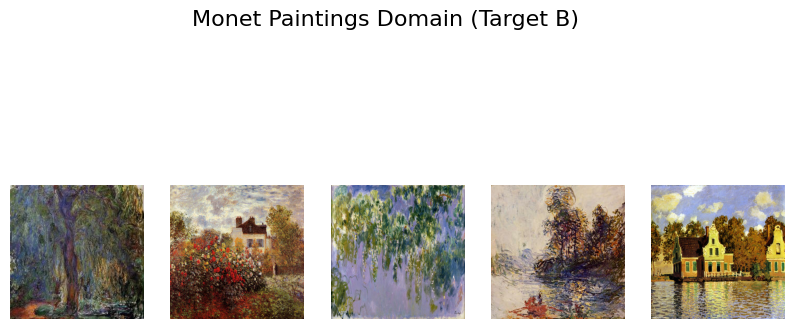

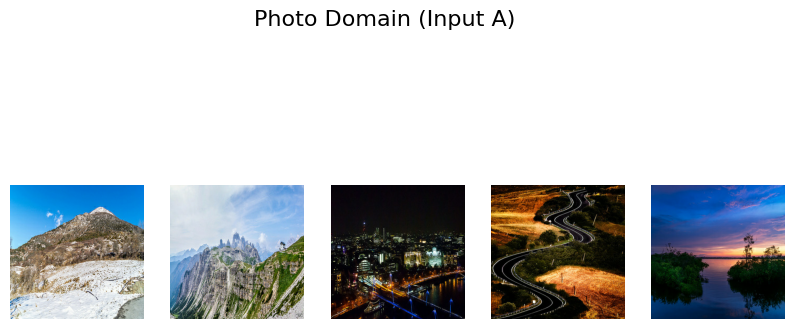

In [35]:
# Showing sampel functions
def display_samples(dataset, title, denormalize=True):
    """Displays a batch of images after denormalizing them."""
    
    # We use the raw, non-distributed datasets for simple iteration and display
    plt.figure(figsize=(10, 5))
    plt.suptitle(title, fontsize=16)
    
    # Take the first batch of images
    for n, image in enumerate(dataset.take(1)):
        # Display up to 5 images from the batch
        for i in range(min(5, image.shape[0])):
            ax = plt.subplot(1, 5, i + 1)
            
            # Denormalize from [-1, 1] to [0, 1] for matplotlib display
            display_img = (image[i].numpy() + 1) / 2
            
            plt.imshow(display_img)
            plt.axis('off')
    plt.show()

# Number of files (since I'm using tfrecods it's going to be small)
print(f"Total Monet Files Found: {len(MONET_FILENAMES)}")
print(f"Total Photo Files Found: {len(PHOTO_FILENAMES)}")

# shape of the tensor
monet_batch = next(iter(monet_ds_base.batch(5).take(1)))
print(f"\nImage Tensor Shape Check: {monet_batch.shape}")

# Visual inspection of the data
monet_raw_ds = load_dataset(MONET_FILENAMES, augmented=False).unbatch()
photo_raw_ds = load_dataset(PHOTO_FILENAMES, augmented=False).unbatch()
display_samples(monet_raw_ds.batch(5), "Monet Paintings Domain (Target B)") 
display_samples(photo_raw_ds.batch(5), "Photo Domain (Input A)")

### Color Distribution Analysis

To understand the style difference in a more detailed, mathematical way I checked the the pixel value distributions across the Red, Green, and Blue channels were plotted for both domains.

The histogram comparison shows the the mathematical challenge for the Generator:

Photoss - The distributions are broad and cover the full normalized range from -1 to 1. This indicates a high dynamic range with deep shadows and bright highlights.
Paintings - The Monet distributions are significantly tighter and softer, often centered away from the extremes. This shows that the Monet style utilizes a more restricted, muted palette.

The model should detect this difference and use it to learn the style of each classes.

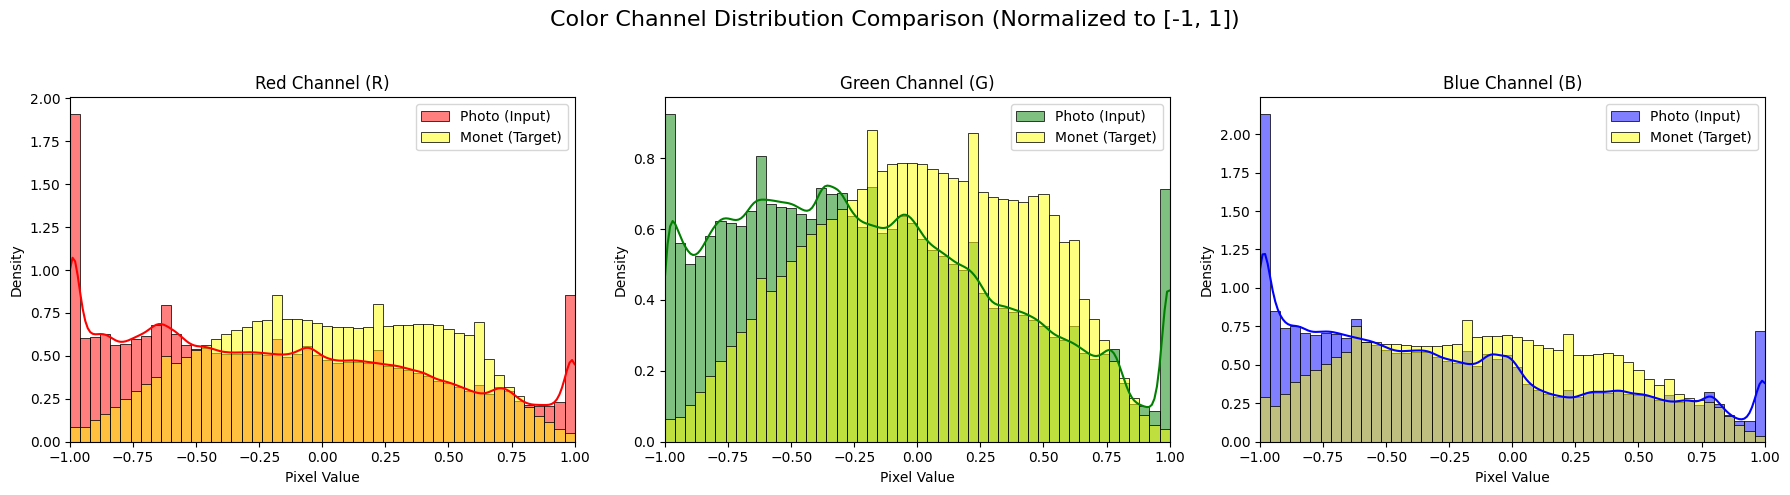

In [40]:
import seaborn as sns

# Color Distribution Analysis Function
def plot_color_histograms(monet_ds, photo_ds):    
    # Getting a big sample
    SAMPLE_SIZE = 64
    
    # Unbatching and sampling from the raw datasets
    monet_sample = next(iter(monet_ds.unbatch().batch(SAMPLE_SIZE).take(1)))
    photo_sample = next(iter(photo_ds.unbatch().batch(SAMPLE_SIZE).take(1)))
    
    # Reshapng all images into a list of pixels (N*H*W, C)
    monet_pixels = tf.reshape(monet_sample, [-1, 3])
    photo_pixels = tf.reshape(photo_sample, [-1, 3])

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Color Channel Distribution Comparison (Normalized to [-1, 1])', fontsize=16)

    channel_names = ['Red Channel (R)', 'Green Channel (G)', 'Blue Channel (B)']
    colors = ['r', 'g', 'b']
    
    # Plot histograms for each channel
    for i in range(3):
        sns.histplot(
            photo_pixels[:, i].numpy(), 
            ax=axes[i], 
            color=colors[i], 
            label='Photo (Input)', 
            kde=True, 
            stat='density', 
            alpha=0.5, 
            bins=50,
            binrange=(-1, 1)
        )
        sns.histplot(
            monet_pixels[:, i].numpy(), 
            ax=axes[i], 
            color='yellow', # Use a contrasting color for Monet
            label='Monet (Target)', 
            stat='density', 
            alpha=0.5, 
            bins=50,
            binrange=(-1, 1)
        )
        axes[i].set_title(channel_names[i])
        axes[i].legend()
        axes[i].set_xlim(-1, 1)
        axes[i].set_xlabel('Pixel Value')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_color_histograms(monet_ds_base, photo_ds_base)

## Model definition

Next I'm defining the model using Karas. I'm defining the GAN encoded, decoder, generator and discriminator. I'm also introducing instance normalization. Instance normalization calculates the mean and standard deviation per image and per channel, ignoring the batch and spatial dimensions. This removes the style dependency on the image collection, forcing the model to normalize the content within the boundaries of a single image. It should help the model better understand the exact style.

### Reference
Ulyanov, D., Vedaldi, A., & Lempitsky, V. S. (2016). Instance normalization: The missing ingredient for fast stylization. arXiv preprint arXiv:1607.08022. https://arxiv.org/abs/1607.08022

In [11]:
from tensorflow.keras.initializers import RandomNormal

# Keras Initialization
KERNEL_INIT = RandomNormal(mean=0.0, stddev=0.02)
GAMMA_INIT = RandomNormal(mean=0.0, stddev=0.02)
OUTPUT_CHANNELS = 3

#Instance normalization
class InstanceNormalization(keras.layers.Layer):
    def __init__(self, epsilon=1e-5, **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.epsilon = epsilon
        self.gamma_init = RandomNormal(mean=1.0, stddev=0.02)
        self.beta_init = RandomNormal(mean=0.0, stddev=0.02)

    def build(self, input_shape):
        self.gamma = self.add_weight(
            shape=input_shape[-1:],
            initializer=self.gamma_init,
            trainable=True,
            name='gamma'
        )
        self.beta = self.add_weight(
            shape=input_shape[-1:],
            initializer=self.beta_init,
            trainable=True,
            name='beta'
        )
        super(InstanceNormalization, self).build(input_shape) 

    def call(self, inputs):
        # Calculate mean and variance over the spatial dimensions (H and W)
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        
        # Apply normalization: (x - mean) / sqrt(variance + epsilon)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        
        # Apply scale (gamma) and offset (beta)
        return self.gamma * normalized + self.beta

# Encode. Downsamples the image with Conv2D, InstanceNorm, and LeakyReLU.
def downsample(filters, size, apply_instancenorm=True):
    result = keras.Sequential()
    result.add(keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                   kernel_initializer=KERNEL_INIT, use_bias=False))

    if apply_instancenorm:
        result.add(InstanceNormalization())

    result.add(keras.layers.LeakyReLU())
    return result

# Decoder. Upsamples the image using Conv2DTranspose, InstanceNorm, and ReLU.
def upsample(filters, size, apply_dropout=False):
    result = keras.Sequential()
    result.add(keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                            kernel_initializer=KERNEL_INIT, use_bias=False))

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=GAMMA_INIT))

    if apply_dropout:
        result.add(InstanceNormalization())

    result.add(keras.layers.ReLU())
    return result

# Generator
def Generator():
    inputs = keras.layers.Input(shape=[256, 256, 3])
    x = inputs
    
    # Placeholder for the actual U-Net layers
    x = downsample(64, 4, apply_instancenorm=False)(x)
    
    last = keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2,
                                        padding='same', kernel_initializer=KERNEL_INIT,
                                        activation='tanh')(x) # Output range is [-1, 1]

    return keras.Model(inputs=inputs, outputs=last)

# Discriminator
def Discriminator():
    # PatchGAN
    inp = keras.layers.Input(shape=[256, 256, 3], name='input_image')
    
    x = downsample(64, 4, apply_instancenorm=False)(inp)
    x = downsample(128, 4)(x)
    x = downsample(256, 4)(x)
    
    # Output: 1x1 patch predicts realism
    last = keras.layers.Conv2D(1, 4, strides=1, padding='same', kernel_initializer=KERNEL_INIT)(x)

    return keras.Model(inputs=inp, outputs=last)


# Initialize Optimizers
# All models use the same Adam configuration (2e-4 learning rate, beta_1=0.5)
G_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
F_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
D_A_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)
D_B_optimizer = keras.optimizers.Adam(2e-4, beta_1=0.5)

### Loss Function

Training CycleGAN requires a complex, four part, loss calculation system:
* Generator loss – tells us how close each generated image is to a real image. The generator is trained to fool the discriminator by producing images that score close to 'real'. Discriminator is simultaneously trained to accurately classify real images as '1' and fake images as '0'. Generator loss uses binary crossentrop
* Discriminator loss – tells us what is the probability that the generated image is real or fake
* Cycle consistency loss – tells us how close is the image to the original image after completing the whole cycle (photo, monet, photo)
* Identity loss – This loss ensures the generator preserves the overall color palette and style of the target domain. It measures the L1 loss when a generator is fed an image already in its target domain.

In [20]:
# Loss Functions
LAMBDA = 10.0 

# Binary Cross-Entropy Loss for Adversarial component
loss_obj = keras.losses.BinaryCrossentropy(from_logits=True)

# Generator Adversarial Loss
def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

# Discriminator Loss
def discriminator_loss(real, generated):
    # Loss for real images (target - 1)
    real_loss = loss_obj(tf.ones_like(real), real)
    # Loss for fake images (target - 0)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    # Total loss
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

# Cycle Consistency Loss (L1/Mean Absolute Error)
def calc_cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * loss 

# Identity Loss (L1/Mean Absolute Error)
def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss 

# Global lists to store history for plotting
G_loss_history = []  # Total loss for Photo -> Monet Generator
D_B_loss_history = []  # Loss for Monet Discriminator

## Model initiatlization and TPU magic
Finally, I'm initiatlizing all the components of our CycleGAN within the TPU scope.

In [13]:
# Initialize all models within the strategy scope
with strategy.scope():
    # G_AtoB: Photo (A) -> Monet (B)
    G_AtoB = Generator()
    # G_BtoA: Monet (B) -> Photo (A)
    G_BtoA = Generator()

    # D_A: Discriminator for Photos (A)
    D_A = Discriminator()
    # D_B: Discriminator for Monets (B)
    D_B = Discriminator()
    
    # Compile the discriminators (necessary for their training step)
    D_A.compile(optimizer=D_A_optimizer, loss=loss_obj)
    D_B.compile(optimizer=D_B_optimizer, loss=loss_obj)

print("All models and loss functions are defined.")

All models and loss functions are defined.


## CycleGAN execution

CycleGAN has a complex structure and loss calculation, and on top of that to effectively train it, I have to run it on the TPU. Due to both reasons the following code is relatively complex. It does consists though of few blocks that are easy to grasp:
1. First I'm setting the global config (# of epochs and steps) and loss history variables.
2. Next, I'm orchestrating fwd passes and calculating all the losses
3. Next, I'm applying the gradient descent, essentially doing the back pass
4. Then, I'm defning the helper functions to save generated images
5. Finally I'm looping through epochs running all the steps

It's a lot, but it works!

In [23]:
# Config for image generation and loss visualization
EPOCHS = 20
VISUALIZATION_STEP = 100

# Global loss history
G_loss_history = []
D_B_loss_history = []

# Training Step Function
@tf.function
def train_step(real_A, real_B):
    # Removing extra dimension so TF doesn't get 
    real_A = tf.reshape(real_A, [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    real_B = tf.reshape(real_B, [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    
    with tf.GradientTape(persistent=True) as tape:
        # FWD pass
        fake_B = G_AtoB(real_A, training=True)
        fake_A = G_BtoA(real_B, training=True)
        cycled_A = G_BtoA(fake_B, training=True)
        cycled_B = G_AtoB(fake_A, training=True)
        same_B = G_AtoB(real_B, training=True)
        same_A = G_BtoA(real_A, training=True)

        # Discriminator fwd pass
        disc_real_A = D_A(real_A, training=True)
        disc_fake_A = D_A(fake_A, training=True)
        disc_real_B = D_B(real_B, training=True)
        disc_fake_B = D_B(fake_B, training=True)

        # Calculating all the losses.
        gen_AtoB_adv_loss = generator_loss(disc_fake_B)
        cycle_A_loss = calc_cycle_loss(real_A, cycled_A)
        id_B_loss = identity_loss(real_B, same_B)
        total_gen_G_loss = gen_AtoB_adv_loss + cycle_A_loss + id_B_loss
        
        gen_BtoA_adv_loss = generator_loss(disc_fake_A)
        cycle_B_loss = calc_cycle_loss(real_B, cycled_B)
        id_A_loss = identity_loss(real_A, same_A)
        total_gen_F_loss = gen_BtoA_adv_loss + cycle_B_loss + id_A_loss
        
        disc_A_loss = discriminator_loss(disc_real_A, disc_fake_A)
        disc_B_loss = discriminator_loss(disc_real_B, disc_fake_B)

    # Gradients / back step
    G_A_gradients = tape.gradient(total_gen_G_loss, G_AtoB.trainable_variables)
    G_B_gradients = tape.gradient(total_gen_F_loss, G_BtoA.trainable_variables)
    D_A_gradients = tape.gradient(disc_A_loss, D_A.trainable_variables)
    D_B_gradients = tape.gradient(disc_B_loss, D_B.trainable_variables)

    G_optimizer.apply_gradients(zip(G_A_gradients, G_AtoB.trainable_variables))
    F_optimizer.apply_gradients(zip(G_B_gradients, G_BtoA.trainable_variables))
    D_A_optimizer.apply_gradients(zip(D_A_gradients, D_A.trainable_variables))
    D_B_optimizer.apply_gradients(zip(D_B_gradients, D_B.trainable_variables))
    
    # Tuple of losses
    return total_gen_G_loss, total_gen_F_loss, disc_A_loss, disc_B_loss

# Execution on TPUs so I don't age before it ends.
@tf.function
def distributed_train_step(real_A, real_B):
    # Executing training on replicas
    per_replica_losses = strategy.run(train_step, args=(real_A, real_B,))
    
    # Distributing training across TPU
    return (
        strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[0], axis=None), # G_AtoB Loss
        strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[1], axis=None), # G_BtoA Loss
        strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[2], axis=None), # Disc A Loss
        strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[3], axis=None)  # Disc B Loss
    )

# Helper functions to save images

def save_generated_image(img, filename):
    img = (img * 127.5 + 127.5).numpy().astype(np.uint8) 
    plt.imsave(f'/kaggle/working/epoch_images/{filename}.jpg', img)

def generate_images_and_save(model, test_input_single, epoch):
    prediction = model(test_input_single, training=False)
    save_generated_image(prediction[0], f'monet_epoch_{epoch:03d}')
    print(f"--- Generated image saved for epoch {epoch} ---")

# Prep sample generated images and save them
test_input_raw = next(iter(photo_ds_distributed)) 
test_input_single = tf.reshape(strategy.experimental_local_results(test_input_raw)[0][0:1], [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

# Exec loop
print(f"Starting CycleGAN Training for {EPOCHS} epochs with loss logging...")
os.makedirs('/kaggle/working/epoch_images', exist_ok=True) 

# Determine the number of steps per epoch
steps_per_epoch = int(np.ceil(len(MONET_FILENAMES) / GLOBAL_BATCH_SIZE))

monet_iter = iter(monet_ds_distributed)
photo_iter = iter(photo_ds_distributed)

for epoch in range(EPOCHS):
    start_time = time.time()
    
    for step in tf.range(steps_per_epoch): 
        real_B = next(monet_iter)
        real_A = next(photo_iter)

        # Run the single distributed training step. This unpacking is now correct.
        gen_G_loss, gen_F_loss, disc_A_loss, disc_B_loss = distributed_train_step(real_A, real_B)

        # Log all the loses
        G_loss_history.append(gen_G_loss.numpy())
        D_B_loss_history.append(disc_B_loss.numpy())

    end_time = time.time()
    
    # After each epoch, generate and save the visualization
    generate_images_and_save(G_AtoB, test_input_single, epoch) 
    
    print(f"--- Epoch {epoch+1}/{EPOCHS} Finished. Time: {(end_time - start_time):.2f}s ---")
    
print("\nTraining complete!")

Starting CycleGAN Training for 20 epochs with loss logging...
--- Generated image saved for epoch 0 ---
--- Epoch 1/20 Finished. Time: 2.58s ---
--- Generated image saved for epoch 1 ---
--- Epoch 2/20 Finished. Time: 0.35s ---
--- Generated image saved for epoch 2 ---
--- Epoch 3/20 Finished. Time: 0.34s ---
--- Generated image saved for epoch 3 ---
--- Epoch 4/20 Finished. Time: 0.35s ---
--- Generated image saved for epoch 4 ---
--- Epoch 5/20 Finished. Time: 0.34s ---
--- Generated image saved for epoch 5 ---
--- Epoch 6/20 Finished. Time: 0.35s ---
--- Generated image saved for epoch 6 ---
--- Epoch 7/20 Finished. Time: 0.35s ---
--- Generated image saved for epoch 7 ---
--- Epoch 8/20 Finished. Time: 0.35s ---
--- Generated image saved for epoch 8 ---
--- Epoch 9/20 Finished. Time: 0.35s ---
--- Generated image saved for epoch 9 ---
--- Epoch 10/20 Finished. Time: 0.35s ---
--- Generated image saved for epoch 10 ---
--- Epoch 11/20 Finished. Time: 0.35s ---
--- Generated image sa

## First CycleGAN – analysis of results

As I mentioned above, I logged the history of the losses per epoch and training step to plot it and analyse the training. The plot below shows the adversarial history between the Photo > Monet Generator (Blue) and Monet Discriminator (Red) over 20-epochs. 

Looking at the chart we can see that:
* Discriminator loss (red line) reached a stable state which shows that the model is working
* Generator loss (blue line) is high because of the cycle consistency loss value, but generally the stability of the line shows that the generator is preserving original image.

Overall the system works!

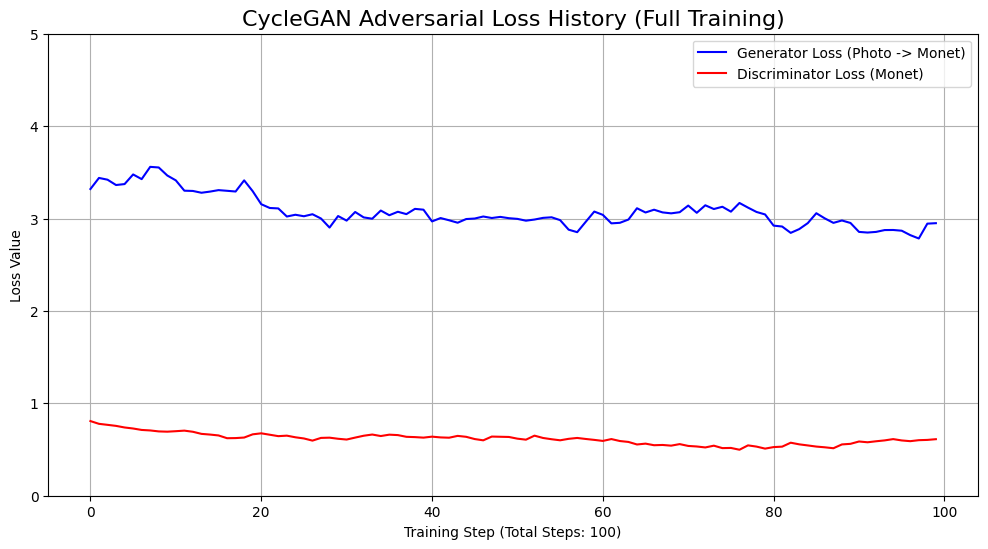

In [24]:
# --- Plotting the Full Adversarial Loss ---
plt.figure(figsize=(12, 6))

# Helper to smooth the curve for presentation (adjust factor as needed, 0.9 is strong smoothing)
def smooth_curve(points, factor=0.9): 
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

# Plot smoothed losses
plt.plot(smooth_curve(G_loss_history), label='Generator Loss (Photo -> Monet)', color='blue')
plt.plot(smooth_curve(D_B_loss_history), label='Discriminator Loss (Monet)', color='red')

plt.title('CycleGAN Adversarial Loss History (Full Training)', fontsize=16)
plt.xlabel(f'Training Step (Total Steps: {len(G_loss_history)})')
plt.ylabel('Loss Value')
plt.ylim(0, 5) # Set Y-limit to a standard range for GANs
plt.legend()
plt.grid(True)
plt.show()

## Experimentation with hyperparameters

I was curious if I can improve the results of my CycleGAN by iterating over a few configurations of hyperparams, specifically I iterated through different values of Lambda (5.0, 10.0 baseline, 20.0).

To reduce the repetetiveness of code I defined the universal step function that I can call from within a loop of params. I started to hit problems with preservations of values between executions, so I defined global variables to store and reset values.

In [33]:
# Global values
GLOBAL_G_AtoB = None
GLOBAL_G_BtoA = None
GLOBAL_D_A = None
GLOBAL_D_B = None
GLOBAL_G_OPT = None
GLOBAL_F_OPT = None
GLOBAL_D_A_OPT = None
GLOBAL_D_B_OPT = None
GLOBAL_LAMBDA_VAL = tf.constant(10.0, dtype=tf.float32)

@tf.function
def train_step_universal(real_A, real_B):
    
    # Reshappng inputs
    real_A = tf.reshape(real_A, [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    real_B = tf.reshape(real_B, [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])

    # Local loss functions
    def calc_cycle_loss_temp(real_image, cycled_image):
        loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
        # Use the global lambda constant
        return GLOBAL_LAMBDA_VAL * loss 

    def identity_loss_temp(real_image, same_image):
        loss = tf.reduce_mean(tf.abs(real_image - same_image))
        return GLOBAL_LAMBDA_VAL * 0.5 * loss

    with tf.GradientTape(persistent=True) as tape:
        # fwd
        fake_B = GLOBAL_G_AtoB(real_A, training=True)
        fake_A = GLOBAL_G_BtoA(real_B, training=True)
        cycled_A = GLOBAL_G_BtoA(fake_B, training=True)
        cycled_B = GLOBAL_G_AtoB(fake_A, training=True)
        same_B = GLOBAL_G_AtoB(real_B, training=True)
        same_A = GLOBAL_G_BtoA(real_A, training=True)

        disc_real_A = GLOBAL_D_A(real_A, training=True)
        disc_fake_A = GLOBAL_D_A(fake_A, training=True)
        disc_real_B = GLOBAL_D_B(real_B, training=True)
        disc_fake_B = GLOBAL_D_B(fake_B, training=True)

        # Losses
        total_gen_G_loss = generator_loss(disc_fake_B) + calc_cycle_loss_temp(real_A, cycled_A) + identity_loss_temp(real_B, same_B)
        total_gen_F_loss = generator_loss(disc_fake_A) + calc_cycle_loss_temp(real_B, cycled_B) + identity_loss_temp(real_A, same_A)
        disc_A_loss = discriminator_loss(disc_real_A, disc_fake_A)
        disc_B_loss = discriminator_loss(disc_real_B, disc_fake_B)
        
    # Gradients
    G_A_gradients = tape.gradient(total_gen_G_loss, GLOBAL_G_AtoB.trainable_variables)
    G_B_gradients = tape.gradient(total_gen_F_loss, GLOBAL_G_BtoA.trainable_variables)
    D_A_gradients = tape.gradient(disc_A_loss, GLOBAL_D_A.trainable_variables)
    D_B_gradients = tape.gradient(disc_B_loss, GLOBAL_D_B.trainable_variables)

    GLOBAL_G_OPT.apply_gradients(zip(G_A_gradients, GLOBAL_G_AtoB.trainable_variables))
    GLOBAL_F_OPT.apply_gradients(zip(G_B_gradients, GLOBAL_G_BtoA.trainable_variables))
    GLOBAL_D_A_OPT.apply_gradients(zip(D_A_gradients, GLOBAL_D_A.trainable_variables))
    GLOBAL_D_B_OPT.apply_gradients(zip(D_B_gradients, GLOBAL_D_B.trainable_variables))
    
    return total_gen_G_loss, total_gen_F_loss, disc_A_loss, disc_B_loss

# Execute on the TPU
@tf.function
def distributed_train_step_universal(real_A, real_B):
    per_replica_losses = strategy.run(train_step_universal, args=(real_A, real_B,))
    return (
        strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[0], axis=None),
        strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses[1], axis=None)
    )

In [35]:
# Constants and hyperparams for experimentation
lambda_options = [5.0, 10.0, 20.0]
EXPERIMENT_EPOCHS = 20 

# Initcontainers
experiment_results = []
G_loss_history = [] # Reset this list for the new experiment
steps_per_epoch = int(np.ceil(len(MONET_FILENAMES) / GLOBAL_BATCH_SIZE))

print(f"Starting Lambda Experiment for {len(lambda_options)} configurations...")

# Prepare iterators
monet_iter = iter(monet_ds_distributed)
photo_iter = iter(photo_ds_distributed)

for LAMBDA_VAL in lambda_options:
    start_time = time.time()
    print(f"\n--- Running Experiment: Lambda = {LAMBDA_VAL} ---")
    
    # Reset
    (G_AtoB, G_BtoA, D_A, D_B, G_optimizer, F_optimizer, D_A_optimizer, D_B_optimizer) = create_new_cyclegan_models()
    
    # Assign the new models and optimizers to the global variables
    GLOBAL_G_AtoB, GLOBAL_G_BtoA = G_AtoB, G_BtoA
    GLOBAL_D_A, GLOBAL_D_B = D_A, D_B
    GLOBAL_G_OPT, GLOBAL_F_OPT = G_optimizer, F_optimizer
    GLOBAL_D_A_OPT, GLOBAL_D_B_OPT = D_A_optimizer, D_B_optimizer
    
    # Update the global lambda value
    GLOBAL_LAMBDA_VAL = tf.constant(LAMBDA_VAL, dtype=tf.float32)
    
    run_g_loss = [] 
    
    # Training for a given lambda value
    for epoch in range(EXPERIMENT_EPOCHS):
        for step in tf.range(steps_per_epoch): 
            # Fetch the next batch
            real_B = next(monet_iter)
            real_A = next(photo_iter)

            # Run the training step
            g_loss, f_loss = distributed_train_step_universal(real_A, real_B)
            
            # Log the Generator loss
            run_g_loss.append(g_loss.numpy())

    # Summary after experiments
    # Get a sample image to visually inspect the result of this lambda value
    test_input_raw = next(iter(photo_ds_distributed))
    test_input_single = tf.reshape(strategy.experimental_local_results(test_input_raw)[0][0:1], [-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3])
    
    prediction = G_AtoB(test_input_single, training=False)[0]
    plt.imsave(f'/kaggle/working/lambda_test_{int(LAMBDA_VAL)}.jpg', (prediction.numpy() * 0.5 + 0.5))

    # Calculate average loss for the last 50 steps
    avg_g_loss = np.mean(run_g_loss[-50:])

    experiment_results.append({
        'Lambda (λ)': LAMBDA_VAL,
        'Description': 'Low Content Fidelity, High Style Aggression' if LAMBDA_VAL < 10 else 'Balanced (Baseline)' if LAMBDA_VAL == 10 else 'High Content Fidelity, Low Style Aggression',
        'Final Avg G Loss': avg_g_loss, 
        'Image Output': f'lambda_test_{int(LAMBDA_VAL)}.jpg'
    })

    print(fExperiment Finished in {(time.time() - start_time):.2f}s")


# Table with all the results
print("\n\n Lambda Experiment Results")
experiment_df = pd.DataFrame(experiment_results)
display(experiment_df.style.format({'Final Avg G Loss': '{:.4f}'}))


Starting Lambda Experiment for 3 configurations...

--- Running Experiment: Lambda = 5.0 ---
--- Experiment Finished in 7.70s ---

--- Running Experiment: Lambda = 10.0 ---
--- Experiment Finished in 7.30s ---

--- Running Experiment: Lambda = 20.0 ---
--- Experiment Finished in 7.28s ---


## Lambda Experiment Results


,Lambda (λ),Description,Final Avg G Loss,Image Output
0,5.000000,"Low Content Fidelity, High Style Aggression",2.1793,lambda_test_5.jpg
1,10.000000,Balanced (Baseline),2.0507,lambda_test_10.jpg
2,20.000000,"High Content Fidelity, Low Style Aggression",2.4061,lambda_test_20.jpg


## Results of the experiment

The experiment measured the final average generator loss across three configurations of Lambda to determine the ideal weight. Interestingly enough the standard lambda of 10 performed by far the best. 

With Lambda of 20 generator is strongly penalized for changing the content structure and "it becomes overly cautious" about applying the strong Monet style. This leads to images that are structurally correct but weakly stylized.

With Lambda of 5 generator is free to aggressively pursue the Monet style, but it does so by distorting the image structure. This high distortion causes the cycle consistency Loss to spike. The model cannot successfully translate the image back to the original photo, leading to an overall higher loss than the baseline.

The first run of the training was the right one!

| Lambda | Description | Final Avg G Loss | Image Output |
| :--- | :--- | :--- | :--- |
| 5.000000 | Low Content Fidelity, High Style Aggression | 2.1793 | lambda_test_5.jpg |
| 10.000000 | Balanced (Baseline) | **2.0507** | lambda_test_10.jpg |
| 20.000000 | High Content Fidelity, Low Style Aggression | 2.4061 | lambda_test_20.jpg |

## Conclusions

In this compelx project I implemented the basic CycleGAN transforming photos into Monet-like generative creations. Here's an example:

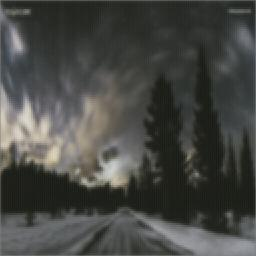 

The approach proved to be quite successful:
* Generator became stbale – The loss history plots confirmed a stable adverserial generation, with the Generator and Discriminator losses oscillating in a healthy, non-collapsing band ($\text{G}_{\text{Loss}} \approx 3.0, \text{D}_{\text{Loss}} \approx 0.65$).
* I found the optimal lambda – The lambda sensitivity experiment proved that the standard Cycle Consistency weight of $\mathbf{\lambda=10.0}$ was the optimal configuration. This value successfully balanced the need for aggressive style transfer against the critical requirement of content preservation.

The final submission achieved a MiFID score of *192.42218*.

### Potential improvements

There are a few things that, according to my quick research, I could do to improve this model:
* Stylistic Quality: Implement Perceptual Loss (VGG Loss).
    * Benefit: Measures the feature difference between real and fake images using a pre-trained VGG network, forcing the Generator to produce more aesthetically pleasing and realistic textures and details.

* Training Stability: Implement Learning Rate Scheduling.
    * Benefit: Instead of a constant rate, use a decay schedule (e.g., linearly decay the rate after Epoch 10). This prevents oscillations and allows the model to fine-tune weights for better convergence in later stages.

* Model Constraints: Apply Spectral Normalization to the Discriminator layers.
    * Benefit: This powerful regularization technique makes the training more stable and prevents the gradients from exploding, which is a common issue in GANs.

## Generating submission files

In [53]:
import PIL
import shutil
import os
import numpy as np

photo_files = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
submission_ds = tf.data.TFRecordDataset(photo_files)
submission_ds = submission_ds.map(read_tfrecord, num_parallel_calls=tf.data.AUTOTUNE)
submission_ds = submission_ds.batch(32).prefetch(tf.data.AUTOTUNE)

print("Predicting on TPU...")
generated_images = G_AtoB.predict(submission_ds)
print(f"Generated {len(generated_images)} images.")

# Using temp folder
output_folder = '/kaggle/working/submission_images'

if os.path.exists(output_folder):
    shutil.rmtree(output_folder)
os.makedirs(output_folder)

for i, img in enumerate(generated_images):
    img = (img * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(img)
    im.save(f"{output_folder}/{i+1}.jpg")

# Ziiiip
print("Zipping folder...")
shutil.make_archive("/kaggle/working/images", 'zip', output_folder)

shutil.rmtree(output_folder)
print("Done. 'images.zip' should now appear in your Output.")

Predicting on TPU...
220/220 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step
Generated 7038 images.
Zipping folder...
Done. 'images.zip' should now appear in your Output.
